In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
import argparse
import os
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection
from scipy import stats

from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcNumHBD    
from rdkit.Chem.rdMolDescriptors import CalcNumHBA
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit import Chem
from rdkit.Chem.QED import qed

from utils import decode_smiles_from_indexes, load_dataset
import matplotlib.pyplot as plt
from scipy.special import softmax

from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

In [2]:
X_train, X_test, charset = load_dataset('./data/processed.h5')

y_train = np.load("./prop_np/weight/y_train_norm.npy")
y_test = np.load("./prop_np/weight/y_test_norm.npy")

#pdf_train = np.load("./prop_np/hbd/pdf_train.npy")
#pdf_test = np.load("./prop_np/hbd/pdf_test.npy")

In [3]:
y_train.shape

(40000,)

In [4]:
y_train_ic = np.repeat(y_train[:,np.newaxis], 33, -1)/10
y_test_ic = np.repeat(y_test[:,np.newaxis], 33, -1)/10

In [5]:
lat_dim = 128

In [6]:
y_train_l = np.repeat(y_train[:, np.newaxis], lat_dim, axis=1)
y_test_l = np.repeat(y_test[:, np.newaxis], lat_dim, axis=1)

y_train_l[:,2:] = 0.
y_test_l[:,2:] = 0.

In [7]:
torch_X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.FloatTensor)

torch_ic_train = torch.from_numpy(y_train_ic).type(torch.FloatTensor) 
torch_ic_test = torch.from_numpy(y_test_ic).type(torch.FloatTensor)

torch_l_train = torch.from_numpy(y_train_l).type(torch.FloatTensor) 
torch_l_test = torch.from_numpy(y_test_l).type(torch.FloatTensor)

torch_lc_train = torch.from_numpy(y_train/10).type(torch.FloatTensor) 
torch_lc_test = torch.from_numpy(y_test/10).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(torch_X_train, torch_ic_train, torch_l_train, torch_lc_train)
test = torch.utils.data.TensorDataset(torch_X_test, torch_ic_test, torch_l_test, torch_lc_test)

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear_3 = nn.Linear(129, 256) ##161
        self.linear_4 = nn.Linear(256, 1344)
        self.conv_4 = nn.ConvTranspose2d(64,32, kernel_size=(11,3), stride=(2,2), padding=0,output_padding=(0,0))
        self.conv_5 = nn.ConvTranspose2d(32,16, kernel_size=(11,3), stride=(2,2), padding=0,output_padding=(0,1))
        self.conv_6 = nn.ConvTranspose2d(16,1, kernel_size=(11,3), stride=(2,2),padding=0,output_padding=(1,0))
        self.relu = nn.ReLU()
    
    def forward(self, z, y):
        z_cond = torch.cat((z,y.unsqueeze(1)), dim=1)
        z_cond = F.selu(self.linear_3(z_cond))
        z_cond = F.selu(self.linear_4(z_cond))
        z_cond = z_cond.view(z_cond.size(0), 64, 7, 3)# (N,C,H)\n",
        z_cond = self.relu(self.conv_4(z_cond))
        z_cond = self.relu(self.conv_5(z_cond))
        z_cond = self.relu(self.conv_6(z_cond))
        y0 = z_cond.contiguous().view(z_cond.size(0), -1) # (N,C,H)\n",
        y1 = F.softmax(y0, dim=1)
        y = y1.contiguous().view(z_cond.size(0), z_cond.size(2), z_cond.size(3))
        
        return y

In [9]:
class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv2d(1, 16, (11,3), stride=(2,2))
        self.conv_2 =nn.Conv2d(16, 32, (11,3), stride=(2,2))
        self.conv_3 = nn.Conv2d(32, 64, (11,3), stride=(2,2))
        self.linear_0 = nn.Linear(1344, 256)
        self.linear_1 = nn.Linear(256, lat_dim)
        self.linear_2 = nn.Linear(256, lat_dim)
        self.relu = nn.ReLU()
        self.decode = Decoder()
        
    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)
    
    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def forward(self, x, y, y_arg):
        x_cond = torch.cat((x,y.view(y.size(0), 1, 1, -1)), dim=2)
        z_mean, z_logvar = self.encode(x_cond)
        z = self.sampling(z_mean, z_logvar)
        decoder = self.decode(z, y_arg)
        
        return decoder, z_mean, z_logvar,z

In [10]:
train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=250)
test_loader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=250)

In [11]:
def vae_loss(x_decoded_mean, x, z_mean, z_logvar, y_arg):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - (z_mean-y_arg).pow(2) - z_logvar.exp())
    return 0.1*xent_loss + kl_loss, kl_loss

In [12]:
torch.manual_seed(42)
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MolecularVAE().to(device)
optimizer = optim.Adam(model.parameters())

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    KL_loss = 0
    latent_arr = []
    label_arr = []
    for batch_idx, data in enumerate(train_loader):
        oh, ic, l, lc = data
        oh,label_ic,label_l, label_lc = oh.unsqueeze(1).to(device),ic.to(device),l.to(device),lc.to(device)
        optimizer.zero_grad()
        output, mean, logvar,latent = model(oh, label_ic,label_lc)
        loss, kl_loss = vae_loss(output, oh.squeeze(1), mean, logvar, label_l)
        loss.backward()
        train_loss += loss
        KL_loss+=kl_loss
        optimizer.step()
        latent_arr.append(latent.cpu().detach().numpy())
        label_arr.append(label_l.cpu().detach().numpy()[:,:7])
        
    print('train', train_loss / len(train_loader.dataset))
    print('train KL', KL_loss / len(train_loader.dataset))
    
    return train_loss / len(train_loader.dataset),latent_arr, label_arr

In [14]:
def test(epoch):
    model.eval()
    test_loss = 0
    KL_loss = 0
    for batch_idx, data in enumerate(test_loader):
        oh, ic, l, lc = data
        oh,label_ic,label_l, label_lc = oh.unsqueeze(1).to(device),ic.to(device),l.to(device),lc.to(device)
        optimizer.zero_grad()
        output, mean, logvar,latent = model(oh, label_ic,label_lc)
        loss, kl_loss = vae_loss(output, oh.squeeze(1), mean, logvar, label_l)
        KL_loss+=kl_loss
        test_loss += loss
    print('test', test_loss / len(test_loader.dataset))
    print('test KL', KL_loss / len(test_loader.dataset))
    
    return test_loss / len(test_loader.dataset)

In [15]:
for epoch in range(1, epochs + 1):
    train_loss,latent_arr,label_arr = train(epoch)
    test_loss = test(epoch)

/home/yi/anaconda3/envs/dl/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train tensor(19129.6797, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(19056.4023, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(5093.7646, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(5025.6118, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(19464.6484, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(19396.9688, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(6309.5225, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(6242.2764, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(5601.2734, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(5534.2803, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(5093.0239, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(5026.1968, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(5021.2969, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(4954.5864, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(4749.0312, device='cuda:0', grad_fn=<DivBackward0>)
test KL

test tensor(734.7490, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(668.7701, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(733.6197, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(667.6089, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(748.3664, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(682.3007, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(688.1820, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(622.2819, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(709.5385, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(643.4340, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(664.0333, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(598.0781, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(750.5111, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(684.0368, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(676.7803, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(610.8442, d

test tensor(390.2633, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(324.8399, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(323.6757, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(258.6082, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(326.4631, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(261.4069, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(306.1691, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(241.1340, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(372.5363, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(306.9749, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(299.0853, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(234.0354, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(287.4873, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(221.9929, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(286.6093, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(221.6336, d

test tensor(201.4485, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(137.3550, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(181.1116, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(116.4756, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(228.1294, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(163.5940, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(176.8634, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(112.1548, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(280.4568, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(215.4492, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(184.2684, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(119.6837, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(203.7922, device='cuda:0', grad_fn=<DivBackward0>)
test KL tensor(138.6597, device='cuda:0', grad_fn=<DivBackward0>)
train tensor(194.5584, device='cuda:0', grad_fn=<DivBackward0>)
train KL tensor(130.0167, d

In [16]:
latent_np = np.array(latent_arr)

In [17]:
latent_np = latent_np[:,:,:2].reshape((-1,2))

In [18]:
label_np = np.array(label_arr)

In [19]:
label_np = label_np[:,:,:2].reshape((-1,2))

In [20]:
label_np.shape

(40000, 2)

In [21]:
latent_np.shape

(40000, 2)

np.save("./prop_np/logP/latent.npy", latent_np)
np.save("./prop_np/logP/label.npy", label_np)

In [22]:
import pandas as pd

latten_pd = pd.DataFrame({
        'x': latent_np[:, 0],
        'y': latent_np[:, 1],
        'label': label_np[:,0]})

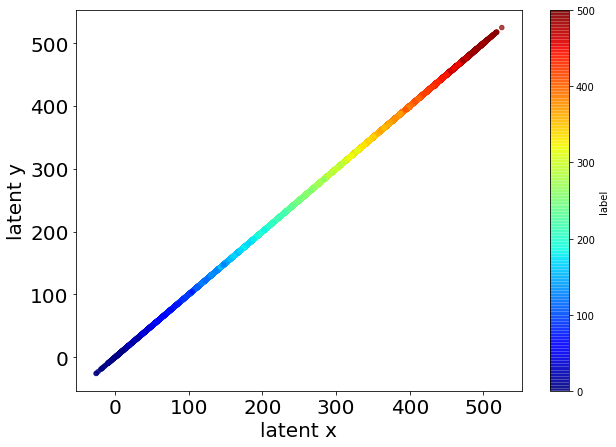

In [23]:
im = latten_pd.plot(kind="scatter", x='x', y='y', alpha=0.7, figsize=(10,7),
    c='label', cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

#im.axes.set_title("CVAE Latent Distribution",y=1.05, fontsize=25)
im.set_xlabel("latent x",fontsize=20)
im.set_ylabel("latent y",fontsize=20)
im.tick_params(labelsize=20)


#plt.savefig("./image/logP.jpg", format='jpg',edgecolor='none', dpi=300)
plt.show()

In [24]:
 def reconstructed(autoencoder, charset, p1):
    valid_smile = []
    p1 = (p1 - 150.025)/201.13*500

    nums = 1000
    x = np.linspace(0, 10, 33)

    prop_np  = np.zeros((nums, 128))
    prop_np[:,0:2] = np.ones((nums,2))*p1
    
    p_ar = np.array([p1/10])
    p = np.repeat(p_ar[:], nums,0)
    for i in range(100):
        
        lat =  np.random.normal(0, 1., size=(nums, 128)).astype ('float32')    
        lat = lat + prop_np
                
        lat_torch =  torch.Tensor(lat).to(device)
        cond_torch =  torch.Tensor(p).to(device)
        
        output = autoencoder.decode(lat_torch, cond_torch)
        outp = output.cpu().detach().numpy()
        
        for j in range(nums):
            decode_smi = outp[j].reshape(1, 120, len(charset)).argmax(axis=2)[0]
            smi = decode_smiles_from_indexes(decode_smi, charset)
            m = Chem.MolFromSmiles(smi)
            #if (m != None) and (' ' not in smi) and (abs(ExactMolWt(m)-p1)<10*2)  and (abs(MolLogP(m)-p2)<0.548546*2)  and (abs(calculateScore(m)-p3)<0.3176*2) and (abs(qed(m)-p4)<0.0357*2) and (abs(CalcNumHBA(m)-p5)<1*2) and (abs(CalcNumHBD(m)-p6)<1*2)and (abs(CalcTPSA(m)-p7)<7.47*2):
            if (m != None) and (' ' not in smi):
                valid_smile.append(smi)
                
    valid_smile = list(set(valid_smile))

        
    return valid_smile

In [25]:
from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*')

In [26]:
for i in range(11):
    
    valid_smile = reconstructed(model, charset, i*20+100)

    mw = np.zeros((len(valid_smile)))
    for i in range(len(valid_smile)):
        s = valid_smile[i]
        m = Chem.MolFromSmiles(s)
        mw[i] = ExactMolWt(m)

    idx = np.argsort(mw)

    lines = []
    for i in range(len(idx)):
        lines.append(valid_smile[idx[i]] + "     " + str(mw[idx[i]]))

    with open("./text/MW.txt", 'a+') as f:
        f.seek(0)
        data = f.read(100)

        if len(data)>0 :
            f.write("\n")
        for line in lines:
            f.write(line)
            f.write('\n')